# **Perform sentiment analysis on the IMDB movie reviews dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df.isna().sum()

,0
review,0
sentiment,0


In [ ]:
df.duplicated().sum()

np.int64(418)

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize, pos_tag

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    filtered_sentence = ''
    for word in words:
        if word not in stop_words:
            filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [ ]:
def normalize_text(text):
    text = text.lower()
    # get rid of urls
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # get rid of non words and extra spaces
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

In [ ]:
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [ ]:
def stemming(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
X = df["review"]
y = df['sentiment']

one = OneHotEncoder()
y = one.fit_transform(np.asarray(y).reshape(-1,1)).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   shuffle=True)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
vocab_size = 10000
max_length = 50

trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length,
                         padding=padding_type,
                         truncating=trunc_type)

In [ ]:
def build_model():
    model = Sequential()

    model.add(Embedding(vocab_size, 64, input_length=max_length))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(32, return_sequences=True))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(LSTM(32))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    return model, early_stopping

In [ ]:
model, early_stopping = build_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.build(input_shape=(None, max_length))
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 50, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 50, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 50, 32)              │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 50, 32)              │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 50, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 695,938 (2.65 MB)

 Trainable params: 695,938 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 250
history = model.fit(X_train,y_train,epochs=15,batch_size=batch_size,validation_split=.1,callbacks=[early_stopping])

Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6213 - loss: 0.6221 - val_accuracy: 0.7815 - val_loss: 0.4600
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8230 - loss: 0.3999 - val_accuracy: 0.7800 - val_loss: 0.4642
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8552 - loss: 0.3455 - val_accuracy: 0.7740 - val_loss: 0.4778
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8850 - loss: 0.2892 - val_accuracy: 0.7645 - val_loss: 0.5381


In [ ]:
score = model.evaluate(np.asarray(X_test),np.asarray(y_test))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7675 - loss: 0.6211


In [ ]:
print(f"on test split\nLoss: {round(score[0],4)}, accuracy: {round(score[1],2)*100}%")

on test split
Loss: 0.6176, accuracy: 77.0%


In [ ]:
pred = model.predict(X_test)
pred = one.inverse_transform(pred)
test = one.inverse_transform(y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


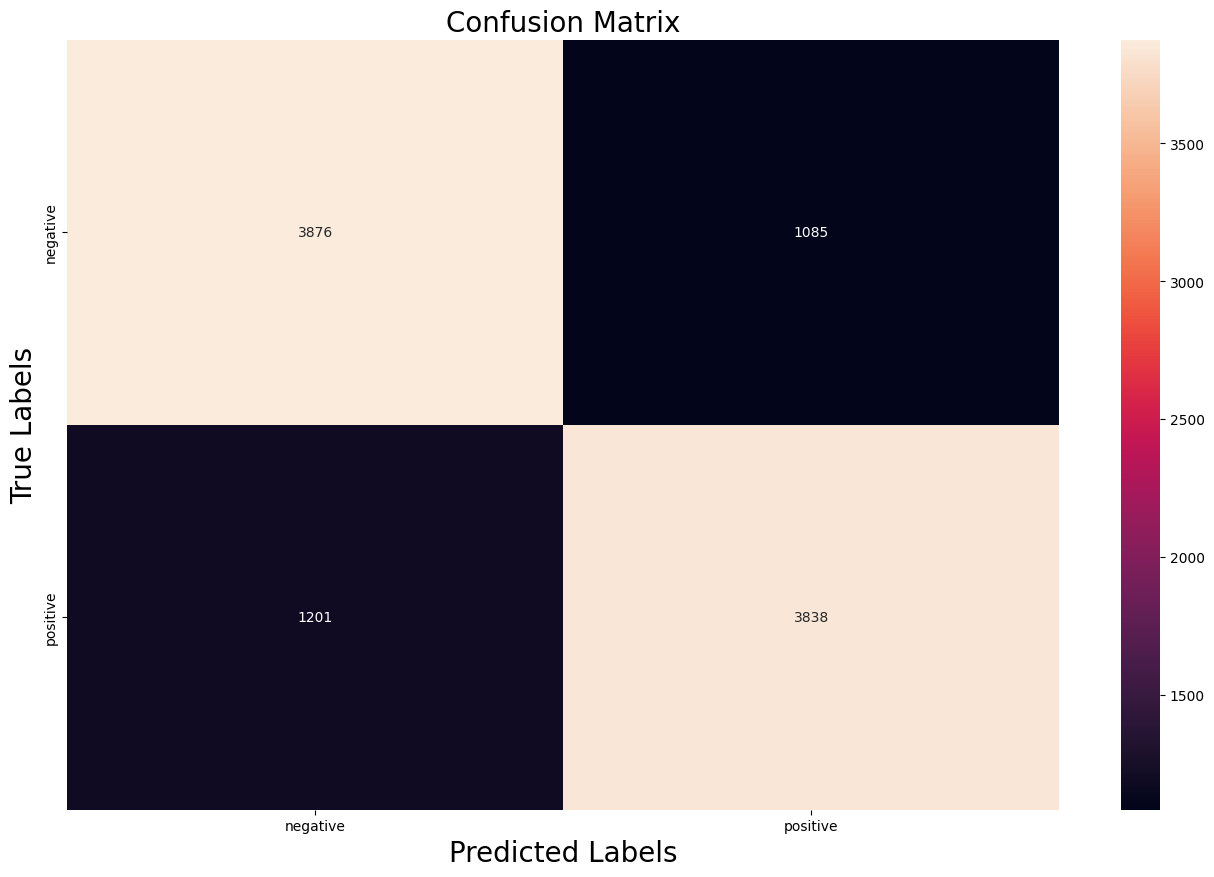

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


matrix = confusion_matrix(test, pred, labels=["negative","positive"])
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt='g')

ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20)
ax.xaxis.set_ticklabels(["negative","positive"], size=10)
ax.yaxis.set_ticklabels(["negative","positive"], size=10)
plt.savefig('confusio_matrix.png')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(test, pred)
print(report)

              precision    recall  f1-score   support

    negative       0.76      0.78      0.77      4961
    positive       0.78      0.76      0.77      5039

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000

